Initial Shape: (48904, 15)
Columns: ['OBJECTID', 'uuid', 'City', 'Surface_area', 'Potential_installable_area', 'Peak_installable_capacity', 'Energy_potential_per_year', 'Assumed_building_type', 'Estimated_tilt', 'Estimated_building_height', 'Estimated_capacity_factor', 'Unit_installation_price', 'Date_added', 'Comment', 'aoi']

Shape after dropping empty cols: (48904, 12)

Missing Values Summary:
 OBJECTID                         0
uuid                             0
City                             0
Surface_area                     0
Potential_installable_area       0
Peak_installable_capacity        0
Energy_potential_per_year        0
Assumed_building_type            0
Estimated_tilt                   0
Estimated_building_height     2939
Estimated_capacity_factor      975
aoi                              0
dtype: int64

Data Types:
 OBJECTID                        int64
uuid                           object
City                           object
Surface_area                  float64


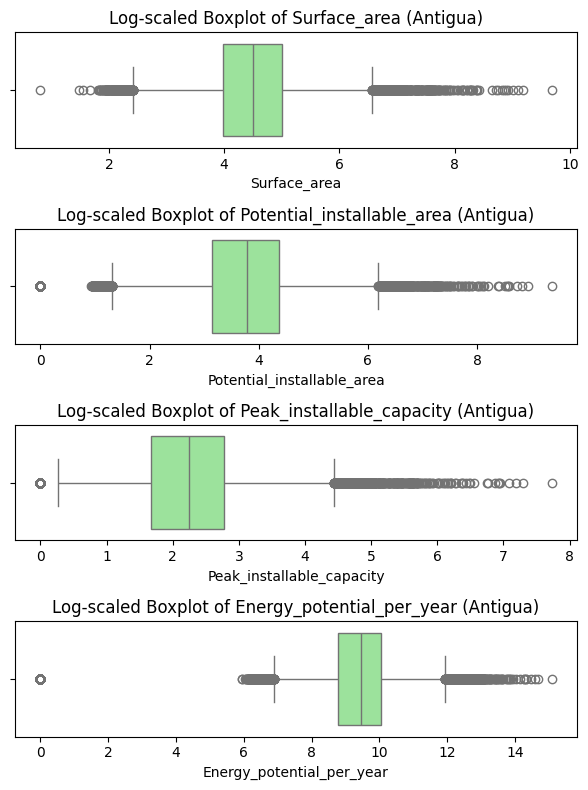


Outlier Summary (99th percentile cutoff):
                       Feature  99th_percentile  Outlier_count  Outlier_%
0                Surface_area       670.867624            490   1.001963
1  Potential_installable_area       441.663192            490   1.001963
2   Peak_installable_capacity        85.622797            490   1.001963
3   Energy_potential_per_year    133353.389219            490   1.001963

Outlier Building Types:
 Assumed_building_type
Commercial                   197
Single-family residential     86
Industrial                    71
Hotels                        60
Public                        59
Schools                       34
Public health facilities      22
Multi-family residential      10
Name: count, dtype: int64

Normal Building Types:
 Assumed_building_type
Single-family residential    42945
Commercial                    2282
Hotels                        1150
Industrial                     659
Schools                        564
Public                         

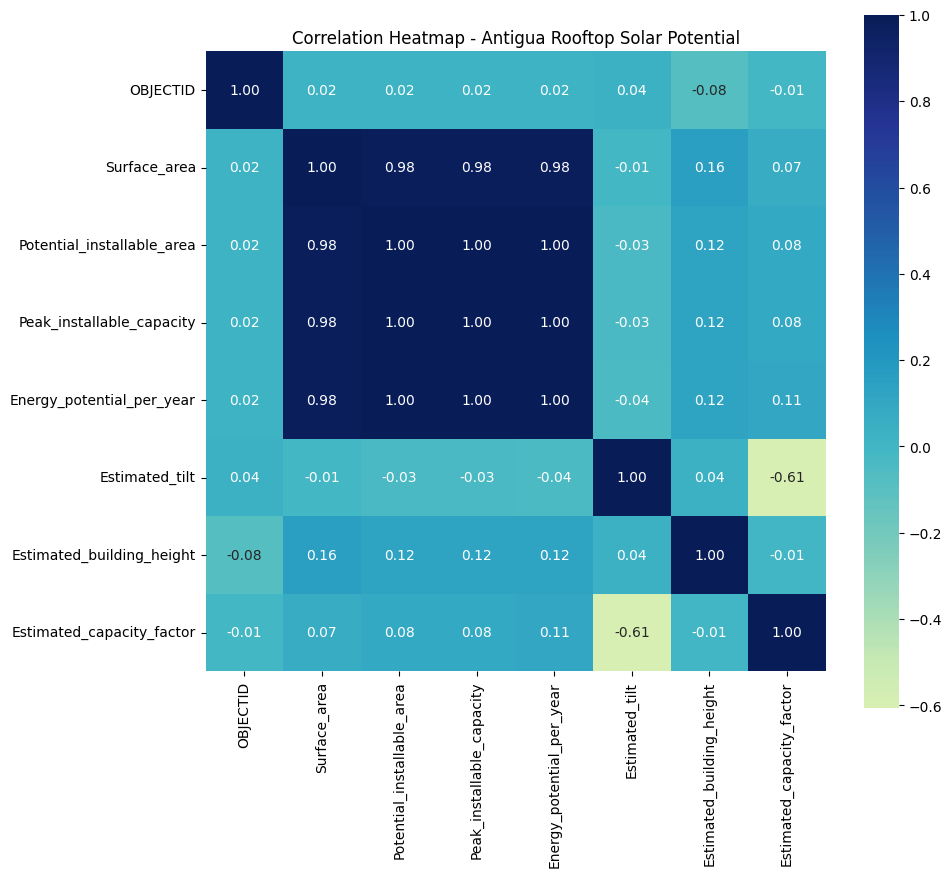

In [1]:
# ======================
# EDA – Rooftop Solar Potential (Antigua)
# ======================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load dataset ---
df = pd.read_csv("datasets/antigua_rooftop_solar_potential.csv")

print("Initial Shape:", df.shape)
print("Columns:", df.columns.tolist())

# --- Drop fully empty columns ---
df = df.drop(columns=['Unit_installation_price', 'Date_added', 'roof_quality', 'Comment'], errors='ignore')
print("\nShape after dropping empty cols:", df.shape)

# --- Missing values summary ---
print("\nMissing Values Summary:\n", df.isna().sum())
print("\nData Types:\n", df.dtypes)

# --- Descriptive statistics ---
print("\nDescriptive Statistics:\n", df.describe().T)

# --- Log-scaled boxplots for key numerical columns ---
numeric_cols = ['Surface_area', 'Potential_installable_area',
                'Peak_installable_capacity', 'Energy_potential_per_year']
plt.figure(figsize=(6, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.boxplot(x=np.log1p(df[col]), color='lightgreen')
    plt.title(f'Log-scaled Boxplot of {col} (Antigua)')
plt.tight_layout()
plt.show()

# --- Outlier detection (99th percentile) ---
outlier_stats = []
for col in numeric_cols:
    q99 = df[col].quantile(0.99)
    outliers = (df[col] > q99).sum()
    outlier_stats.append([col, q99, outliers, outliers / len(df) * 100])
outlier_df = pd.DataFrame(outlier_stats, columns=['Feature', '99th_percentile', 'Outlier_count', 'Outlier_%'])
print("\nOutlier Summary (99th percentile cutoff):\n", outlier_df)

# --- Outlier building type analysis ---
outlier_mask = (df['Surface_area'] > df['Surface_area'].quantile(0.99)) | \
               (df['Potential_installable_area'] > df['Potential_installable_area'].quantile(0.99))
print("\nOutlier Building Types:\n", df.loc[outlier_mask, 'Assumed_building_type'].value_counts())
print("\nNormal Building Types:\n", df.loc[~outlier_mask, 'Assumed_building_type'].value_counts())

# --- Zero check ---
for col in numeric_cols:
    zeros = (df[col] == 0).sum()
    print(f"{col}: {zeros} zeros ({zeros/len(df)*100:.2f}%)")

# --- Filter out zero-value rows for correlation ---
df_nozero = df[
    (df['Potential_installable_area'] > 0) &
    (df['Peak_installable_capacity'] > 0) &
    (df['Energy_potential_per_year'] > 0)
].copy()

print("\nFiltered Shape (no zeros):", df_nozero.shape)

# --- Correlation heatmap ---
corr = df_nozero.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(10, 9))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='YlGnBu', center=0, square=True)
plt.title("Correlation Heatmap - Antigua Rooftop Solar Potential")
plt.show()


🧩 Step 9–10 Analysis – Antigua Rooftop Solar Potential
🧱 1. General structure

48,904 buildings — much smaller sample (island-scale coverage).

Minimal missingness:

Estimated_building_height: 2,939 missing (~6%)

Estimated_capacity_factor: 975 missing (~2%)
→ still a high-quality dataset.

📊 2. Descriptive statistics & scale
| Feature                        |      Mean |                                                         Median | Notes                                                                  |
| :----------------------------- | --------: | -------------------------------------------------------------: | :--------------------------------------------------------------------- |
| **Surface_area**               |     126.7 |                                                           88.9 | Mostly small–medium buildings; compact residential layouts.            |
| **Potential_installable_area** |      68.6 |                                                           43.5 | ~55% of roof area usable — very efficient.                             |
| **Peak_installable_capacity**  |   13.3 kW |                                                         8.4 kW | Similar order as Tegucigalpa, suggesting similar roof types.           |
| **Energy_potential_per_year**  |  20.4 MWh |                                                       12.7 MWh | Lower total yield vs. Accra, consistent with smaller average roofs.    |
| **Tilt**                       |     16.4° |                                                          15.9° | More sloped roofs than Accra — typical Caribbean housing architecture. |
| **Capacity factor**            | 1515 ± 86 | Highest so far → very strong solar irradiance and consistency. |                                                                        |

💡 The slightly higher capacity factor reflects Antigua’s excellent year-round sunlight.

📦 3. Boxplots (log-scaled)

Long right tails again, but shorter than Accra → fewer industrial megastructures.

Left-side zeros visible (we’ll check exact % soon).

Distributions narrower → energy, capacity, and area all vary less across buildings.

🧩 4. Correlation heatmap
| Relationship             |      Correlation      | Observation                                                                             |
| :----------------------- | :-------------------: | :-------------------------------------------------------------------------------------- |
| Area ↔ Capacity ↔ Energy |       ~0.98–1.00      | Same strong physical consistency as before.                                             |
| Tilt ↔ Capacity factor   |       **−0.61**       | Strongest negative tilt-efficiency link so far — higher slopes hurt energy output here. |
| Height ↔ Area            |          0.16         | Slight tendency for taller buildings to have larger roofs (mild).                       |
| Capacity factor ↔ Others | Near zero except tilt | Confirms it’s mostly influenced by sunlight and angle.                                  |

🟩 So Antigua behaves predictably — physical features scale linearly, but tilt strongly controls efficiency.

☀️ 5. Key insights to keep for report

Dataset smaller but very clean — perfect for validation or model generalization tests.

Caribbean-style roofs (sloped) create visible tilt-to-efficiency effects (−0.61).

Excellent irradiance (high mean capacity factor).

Low dispersion in energy potential → stable local solar performance.


In [2]:
# Step 10: Count zeros in key metrics
for col in ['Potential_installable_area', 'Peak_installable_capacity', 'Energy_potential_per_year']:
    zeros = (df[col] == 0).sum()
    print(f"{col}: {zeros} zeros ({zeros/len(df)*100:.2f}%)")


Potential_installable_area: 975 zeros (1.99%)
Peak_installable_capacity: 975 zeros (1.99%)
Energy_potential_per_year: 975 zeros (1.99%)


In [3]:
# Step 11: Identify top 1% outliers and their building types
outlier_mask = (
    (df['Surface_area'] > df['Surface_area'].quantile(0.99)) |
    (df['Potential_installable_area'] > df['Potential_installable_area'].quantile(0.99))
)

print("\nOutlier Building Types:\n", df.loc[outlier_mask, 'Assumed_building_type'].value_counts())
print("\nNormal (non-outlier) Building Types:\n", df.loc[~outlier_mask, 'Assumed_building_type'].value_counts())



Outlier Building Types:
 Assumed_building_type
Commercial                   197
Single-family residential     86
Industrial                    71
Hotels                        60
Public                        59
Schools                       34
Public health facilities      22
Multi-family residential      10
Name: count, dtype: int64

Normal (non-outlier) Building Types:
 Assumed_building_type
Single-family residential    42945
Commercial                    2282
Hotels                        1150
Industrial                     659
Schools                        564
Public                         472
Public health facilities       170
Multi-family residential       123
Name: count, dtype: int64


🧩 Step 10–11 Analysis – Antigua Zero Values & Outlier Building Types
🔹 Zero-value summary
| Metric                         | Zero Count | % of Dataset | Interpretation                                                                                    |
| :----------------------------- | ---------: | -----------: | :------------------------------------------------------------------------------------------------ |
| **Potential_installable_area** |        975 |       1.99 % | Nearly 2% of buildings have no viable solar area (likely shaded, irregular, or very small roofs). |
| **Peak_installable_capacity**  |        975 |       1.99 % | Direct consequence of no usable roof area.                                                        |
| **Energy_potential_per_year**  |        975 |       1.99 % | Those same structures have zero annual energy potential.                                          |

🟢 Interpretation:
The ~2% “zero group” is small but consistent across all cities — indicating uniform processing logic in the rooftop extraction model. These are not missing values, but non-eligible roofs due to shading or small footprint.

🔹 Outlier building types (top 1%)
| Building Type                            | Outlier Count |                                                      Normal Count | Observation                                                                                       |
| :--------------------------------------- | ------------: | ----------------------------------------------------------------: | :------------------------------------------------------------------------------------------------ |
| **Commercial**                           |           197 |                                                             2,282 | Biggest contributor among outliers → retail, hotels, and offices dominate large rooftop category. |
| **Industrial**                           |            71 |                                                               659 | Moderate share, matching Antigua’s smaller industrial base.                                       |
| **Hotels**                               |            60 |                                                             1,150 | Prominent — resort complexes with large flat roofs are typical here.                              |
| **Public / Schools / Health facilities** |      89 total | Public infrastructure forms a small but distinct high-area group. |                                                                                                   |
| **Single-family residential**            |            86 |                                                            42,945 | A few exceptionally large private homes appear.                                                   |
| **Multi-family residential**             |            10 |                                                               123 | Small apartment blocks among top rooftops.                                                        |

🧠 Interpretation

Commercial and tourism-related buildings (e.g., hotels) dominate the high-capacity group — matching the island’s economy structure.

The outlier share (≈1%) is realistic and physically plausible — these are genuine large structures, not anomalies.

Compared to Accra or Tegucigalpa, Antigua’s outliers are more diverse (mix of hotels, public, commercial) rather than heavily industrial.